# Zarządzanie ryzykiem w firmie NVIDIA

Szymon Malec <br>
Michał Wiktorowski <br>
Filip Oszczepaliński <br>
Damian Szuster

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from statistics import stdev
from scipy.stats import median_abs_deviation, skew, kurtosis
from scipy.stats import norm, logistic, laplace
from scipy.stats import pearsonr
from scipy.special import erf
import seaborn as sns; sns.set()

__Zmienne ryzyka__:
- Ceny miedzi
- Ceny aluminium

In [10]:
copper_ = pd.read_csv('data/copper.csv', sep = ',', encoding = 'latin-1')

def equalize(df): #funkcja ta skaluje ceny miedzi do cen za tonę
    d = 2204.623
    col_names = [col for col in df.columns][1:]
    col_names.remove('Volume')
    for name in col_names:
        df[name] = df[name]*d
    return df

copper = equalize(copper_) #ceny miedzi przeskalowane do ton
aluminium = pd.read_csv('data/aluminium.csv', sep = ',', encoding = 'latin-1') #ceny aluminium (przed ucięciem)
idx = aluminium.index[aluminium['Date'] == '07/01/2019'].tolist()[0]
idx # idx = 952
aluminium2 = aluminium.drop(aluminium.index[idx:1259]) #ceny aluminium (po ucięciu)

def draw_stock(df, clr, title): #funkcja rysuje wykres cen
    fig, ax = plt.subplots(figsize = (15, 4))
    plt.xticks(rotation = 45)
    xloc = plt.MaxNLocator(9)
    ax.xaxis.set_major_locator(xloc)
    dates = df['Date'].values[::-1]
    prices = df['Open'].values[::-1]
    plt.plot(dates, prices, color = clr)
    plt.ylabel('USD')
    plt.title(title)
    plt.show()
    
def draw_ret(df, clr, title): #funkcja rysuje wykres log stóp zwrotu
    fig, ax = plt.subplots(figsize = (15, 4))
    plt.xticks(rotation = 45)
    xloc = plt.MaxNLocator(9)
    ax.xaxis.set_major_locator(xloc)
    dates = df['Date'].values[::-1][:-1]
    prices1 = df['Open'].values[::-1][1:]
    prices2 = df['Open'].values[::-1][:-1]
    r = prices1/prices2
    plt.plot(dates, r, color = clr)
    plt.ylabel('USD')
    plt.title(title)
    plt.show()

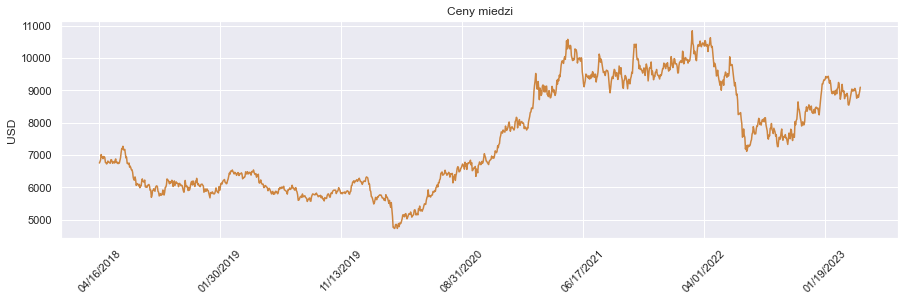

In [11]:
draw_stock(copper, 'peru', 'Ceny miedzi')

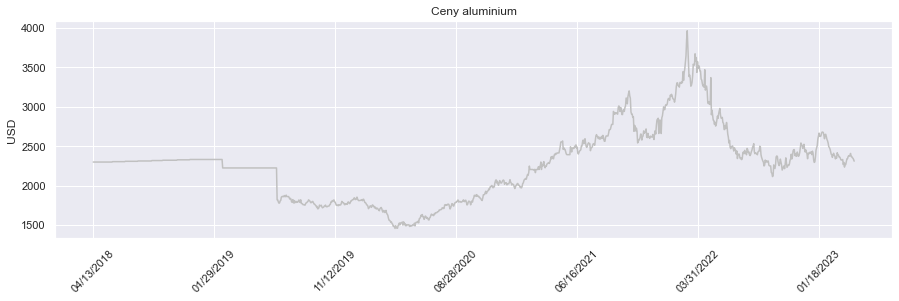

In [13]:
draw_stock(aluminium, 'silver', 'Ceny aluminium')

Na drugim wykresie możemy zauważyć dziwne zachowanie cen aluminium. Może to wynikać z błędów w dysponowanych przez nas danych. W celu uzyskania lepszych rezultatów, usuniemy kawałek danych.

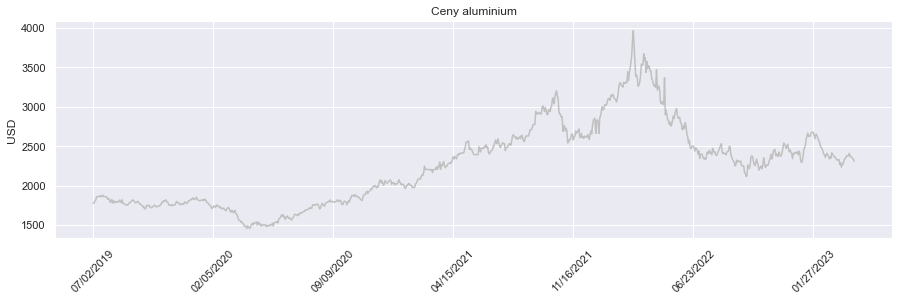

In [12]:
draw_stock(aluminium2, 'silver', 'Ceny aluminium')

Tu wyznaczymy stopy zwrotu ...